# Introduction

The timeseries module provides the TimeSeries class which deals with all 1D timeseries (sizedistribution timeseries are considered 2D timeseries and are delt with in a different place). Usually when reading in any type of data, that is in some way a time series it will end up beeing a TimeSeries instance. Data in a TimeSeries is stored at TimeSeries.data in form of a pandas DataFrame instance.

# Imports

In [1]:
from atmPy.general import timeseries
from atmPy.aerosols.instruments.POPS import housekeeping
from atmPy.aerosols.instruments.piccolo import piccolo
from atmPy.data_archives.arm import read_data

In [2]:
# %matplotlib nbagg
%matplotlib inline

# Load/save

## netCDF

In [7]:
fname = '/Users/htelg/data/20160108_ARM_test/all/sgpnoaaaosC1.b1.20120101.000000.cdf'
aos = read_data.read_cdf(fname)

fname = '/Users/htelg/data/20160108_ARM_test/all/sgptdmaapssizeC1.c1.20120101.091247.cdf'
tdma = read_data.read_cdf(fname, data_quality='patchy')

tdma.size_distribution.index_of_refraction = 1.5
opt = tdma.size_distribution.calculate_optical_properties(550)

opt.extinction_coeff_sum_along_d.data *= 2.2e6

ts = timeseries.TimeSeries(pd.DataFrame(aos.scatt_coeff.data.Bs_B_Dry_10um_Neph3W_1))
ts._data_period = aos.scatt_coeff._data_period

other = opt.extinction_coeff_sum_along_d

tsrm_al = ts.align_to(other)


 /Users/htelg/data/20160108_ARM_test/all/sgpnoaaaosC1.b1.20120101.000000.cdf

 /Users/htelg/data/20160108_ARM_test/all/sgptdmaapssizeC1.c1.20120101.091247.cdf


In [11]:
fname = '/Users/htelg/tmp/text.nc'
ts.save_netCDF(fname)

/Users/htelg/prog/atm-py


In [9]:
ts_out = timeseries.load_netCDF(fname)

## csv

Usually a TimeSeries is generated when data representing a timeseries is loaded, e.g. POPS housekeeping data, or piccolo telemetry data.

In [2]:
pops_hk = housekeeping.read_csv('./data/POPS_housekeeping.csv')
picco_tel = piccolo.read_csv('./data/piccolo.log')

NameError: name 'housekeeping' is not defined

# Features

## merge TimeSeries instances with different time axes

This attribute of a TimeSeries class allows the projection of a different instance on the current one. The resulting instance will have the collumns of both instances but with the time axes according to the first instance.

In [3]:
pops_hk_merged = pops_hk.merge(picco_tel)
# pops_hk_merged.data

After merging it is possible to plot for example the Particle rate as a function of altitude. Columns which where previously in different Timeseries with different time intervals and time values.

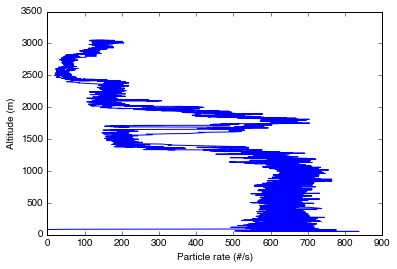

In [4]:
f,ax = plt.subplots()
ax.plot(pops_hk_merged.data.Particle_rate_nops, pops_hk_merged.data.Altitude)
ax.set_ylabel('Altitude (m)')
ax.set_xlabel('Particle rate (#/s)')

## Plot on map (probably not working right now)

When a TimeSeries instance has data columns named 'Lat' and 'Lon' it is possible to do a quick drowing of e.g. fligh path on a map. This uses matplotlib basemap.

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/mpl_toolkits/basemap/__init__.py:1624: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif fill_color == 'none' or fill_color == 'None':


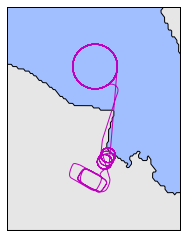

In [36]:
pops_hk_merged.plot_map(resolution = 'f')

# correlate time series

In [6]:
data_product = ['aosacsm', 'noaaaos']
time_window=('2012-01-01', '2012-04-01')
folder = '/Users/htelg/data/ARM/SGP/'
out = read_data.read_cdf(folder, data_product=data_product, time_window=time_window, data_quality='good', verbose=False)

aosacsm = out['aosacsm']
noaaaos = out['noaaaos']

acsm_tm = timeseries.TimeSeries(pd.DataFrame(aosacsm.mass_concentrations.data['total']))
acsm_tm._data_period = aosacsm._data_period

noaa_scatt = timeseries.TimeSeries(pd.DataFrame(noaaaos.scatt_coeff.data['Bs_G_Dry_1um_Neph3W_1']))
noaa_scatt._data_period = noaaaos._data_period

attribute:  abs_coeff
TimeSeries
attribute:  back_scatt
TimeSeries
attribute:  scatt_coeff
TimeSeries
attribute:  RH_nephelometer
TimeSeries
attribute:  mass_concentrations
AMS_Timeseries_lev01
attribute:  organic_mass_spectral_matrix
TimeSeries_2D


(<matplotlib.axes._subplots.AxesSubplot at 0x11a1597b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1116a7c18>)

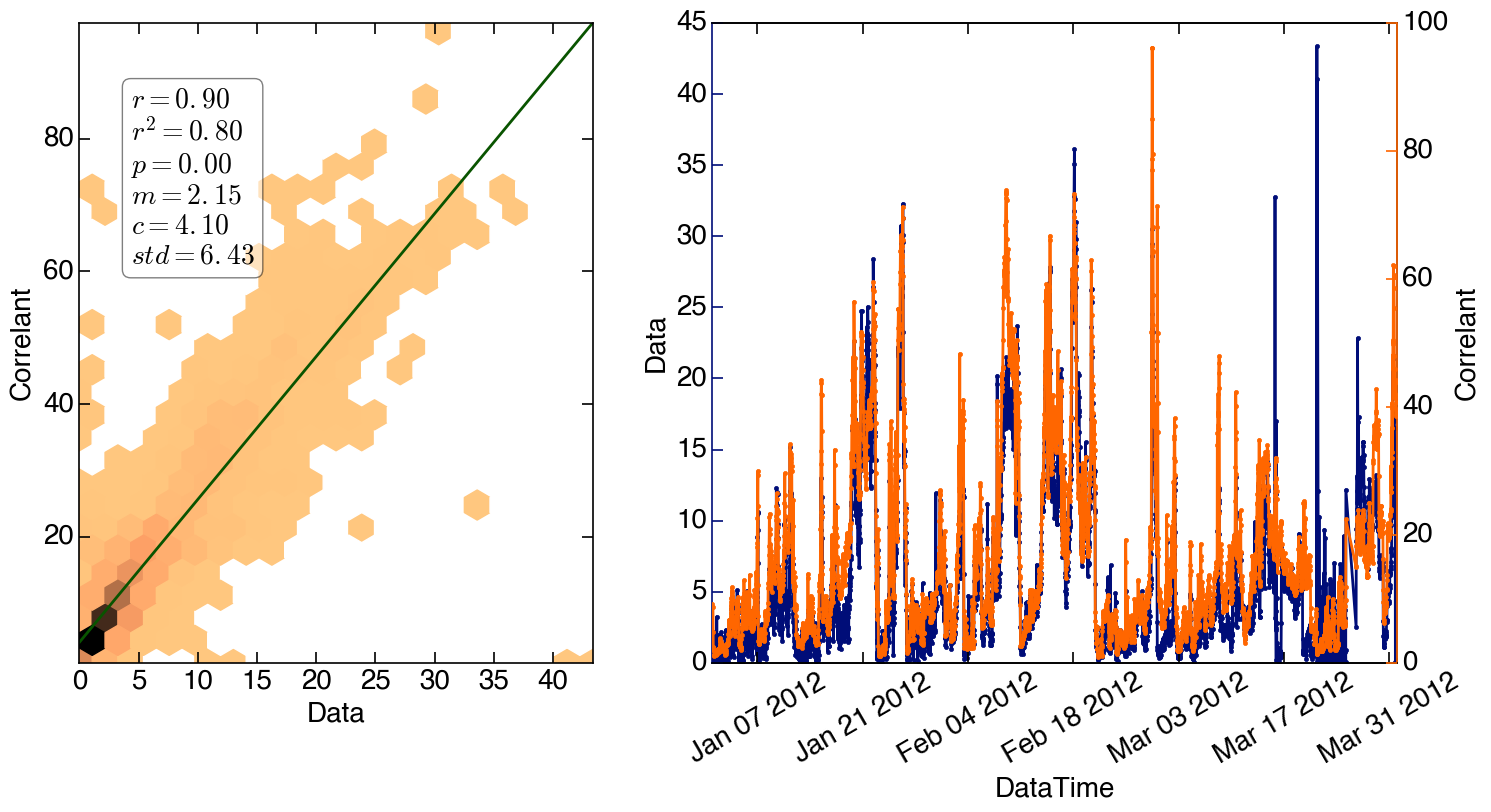

In [7]:
out = acsm_tm.correlate_to(noaa_scatt)
out.plot_pearsonANDoriginal_data()

Each window contains 295 data points of which at least 197 are not nan.


/Users/htelg/prog/atm-py/atmPy/general/timeseries.py:323: FutureWarning: TimeSeries is deprecated. Please use Series
  timestamps = _pd.TimeSeries(_pd.to_datetime(_pd.Series(_np.zeros(size))))


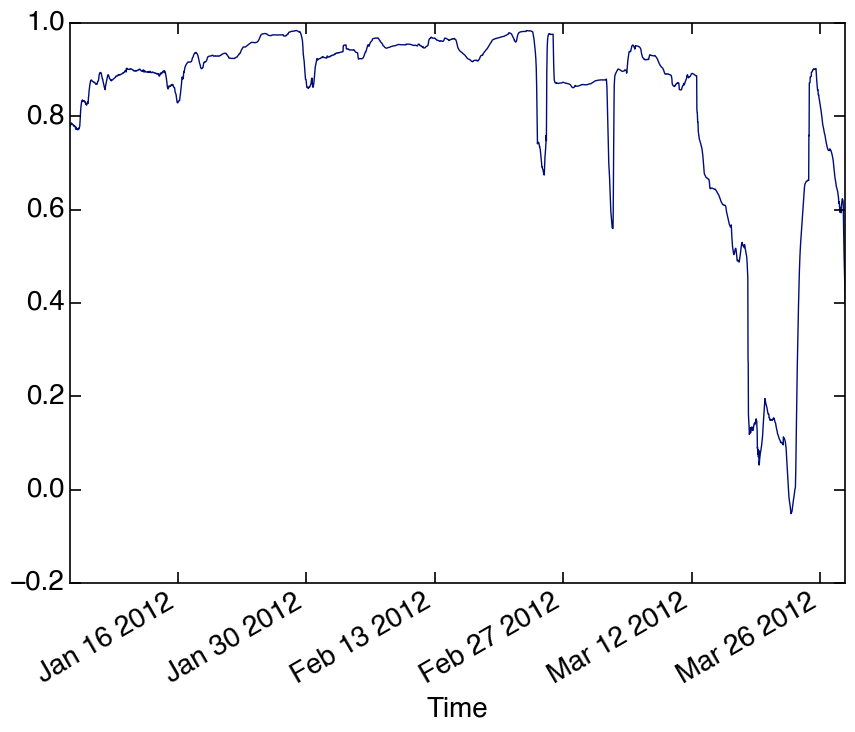

In [16]:
out = acsm_tm.rolling_correlation(noaa_scatt, (7,'D'))
out.plot()